<a href="https://colab.research.google.com/github/R3gm/Colab-resources/blob/main/TPU_Stable_Diffusion_fast_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧨 Fast Stable Diffusion in free Colab with JAX / Flax on TPU!

🤗 Hugging Face [Diffusers](https://github.com/huggingface/diffusers) supports Flax since version `0.5.1`! This allows for snappy inference on Google TPUs, such as those available in Colab, Kaggle or through Google Cloud Platform.

If you want more details about how Stable Diffusion works using JAX please refer to [our blog](https://huggingface.co/blog/stable_diffusion_jax) or [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

| Description | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/huggingface/diffusers?style=social)](https://github.com/huggingface/diffusers) |
| Original Colab | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/Colab-resources/) |


## Initial Steps

In [1]:
#@title Install required libraries
!pip install huggingface_hub==0.10.0 gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gradio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 25.5 MB/s eta 

In [ ]:
#@title Login to the Hugging Face Hub
#@markdown Make sure you also have read and accept the LICENSE of the [Stable Diffusion model](https://huggingface.co/CompVis/stable-diffusion-v1-4), otherwise you may find an error
from huggingface_hub import notebook_login
!git config --global credential.helper store

notebook_login()

## Setup
Run all cells for setting up JAX and the model

In [9]:
#@title Set up JAX
#@markdown If you see an error, make sure you are using a TPU backend. Select `Runtime` in the menu above, then select the option "Change runtime type" and then select `TPU` under the `Hardware accelerator` setting.
# fix jax in https://stackoverflow.com/questions/75729100/cannot-setup-tpu-in-colab-using-any-methods-with-jax
!pip install jax==0.3.25 jaxlib==0.3.25 flax==0.6.2 optax==0.0.2 orbax==0.0.23
#clu dm-haiku==0.0.9
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver_20221011')

!pip install flax diffusers transformers ftfy
jax.devices()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.1.4
    Uninstalling optax-0.1.4:
      Successfully uninstalled optax-0.1.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [2]:
libraries = ['jax', 'jaxlib', 'flax', 'optax', 'orbax']

for library in libraries:
    lib = __import__(library)
    print(f"{library} version:", lib.__version__)


jax version: 0.3.25
jaxlib version: 0.3.25
flax version: 0.6.2
optax version: 0.0.2
orbax version: 0.0.23


In [2]:
#@title Import required libraries
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import torch
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
#@title Load the model
#@markdown It's safe to ignore the warning messages, everything is okay
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jnp.bfloat16)
p_params = replicate(params)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:92: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_model', 'embeddings', 'position_embedding', 'embedding'), ('vi

## Run!

Seed used 1154549736


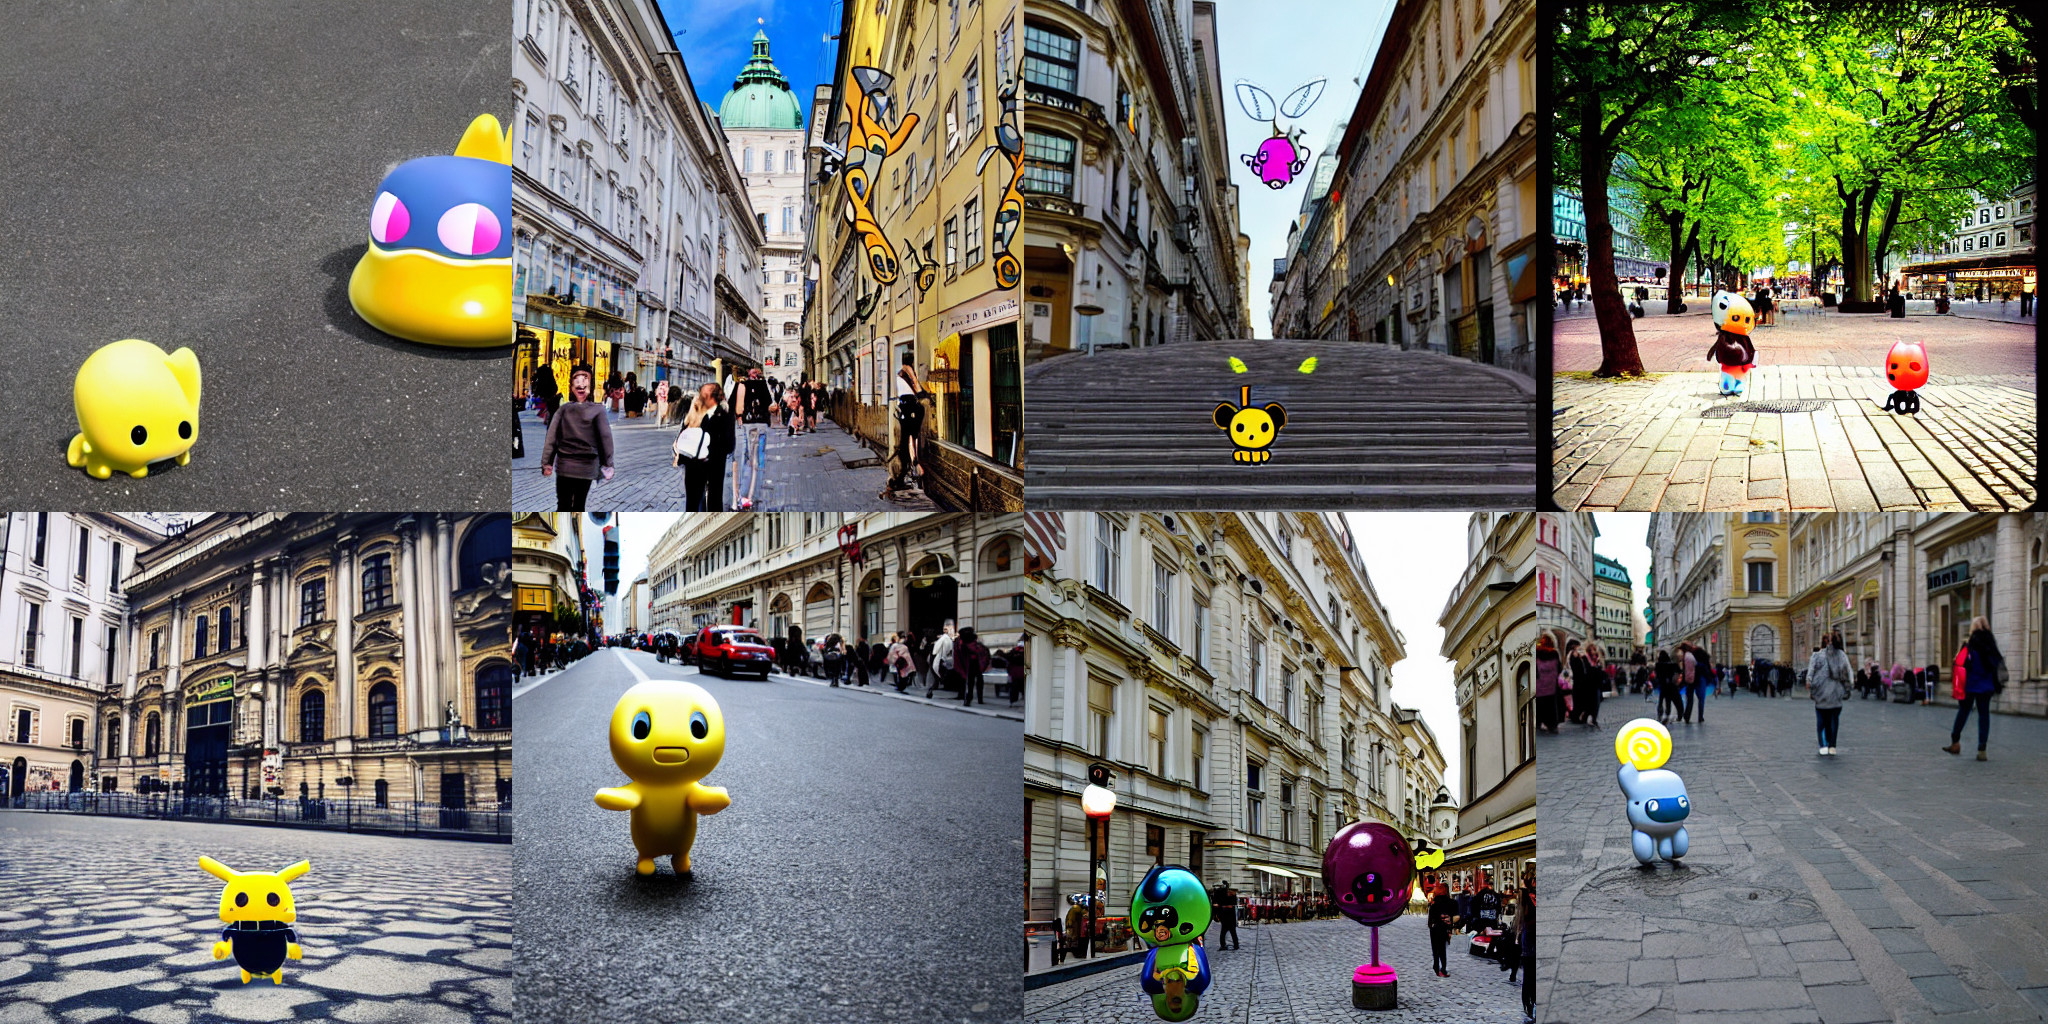

In [4]:
#@title Set and go!
#@markdown First run takes ~50s as it compiles stuff. Then, it should take around ~8s per prompt!
prompt = "the spirit of a tamagotchi wandering in the city of Vienna" #@param {type:"string"}
num_inference_steps = 50 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
#@markdown `-1` will set a random seed. You can replace that to any integer for reproducible results

if(seed == -1):
  import random
  random_int = random.randint(0, 2147483647)
  real_seed = random_int
else:
  real_seed = seed
prng_seed = jax.random.PRNGKey(real_seed)
prng_seed = jax.random.split(prng_seed, jax.device_count())
num_samples = jax.device_count()
prompt = num_samples * [prompt]
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids = shard(prompt_ids)
images = pipeline(prompt_ids, p_params, prng_seed, num_inference_steps, jit=True).images
images_pil = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
if(seed == -1):
  print(f"Seed used {real_seed}")
image_grid(images_pil, 2, 4)


In [5]:
#@title Easy to use and shareble UI with Gradio
#@markdown Run your demo using a Gradio UI like on this screenshot

#@markdown <img src="https://i.imgur.com/H6MtbI5.png" width="900" />
import gradio as gr

def inference(prompt, seed):
    all_images = [] 
    print(seed)
    prng_seed = jax.random.PRNGKey(int(seed))
    prng_seed = jax.random.split(prng_seed, jax.device_count())
    num_samples = jax.device_count()
    prompt = num_samples * [prompt]
    prompt_ids = pipeline.prepare_inputs(prompt)
    prompt_ids = shard(prompt_ids)
    images = pipeline(prompt_ids, p_params, prng_seed, num_inference_steps, jit=True).images
    images_pil = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
    return images_pil

import random
random_int = random.randint(0, 2147483647)
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            seed = gr.Number(label="seed", value=random_int)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False).style(grid=[2])

    run.click(inference, inputs=[prompt, seed], outputs=gallery)
    gr.Examples([["the spirit of a tamagotchi wandering in the city of Vienna", 1,1]], [prompt], gallery, inference, cache_examples=False)


demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

2143267670.0
2143267670.0
2143267670.0
2143267670.0
2143267670.0
2143267670.0
Keyboard interruption in main thread... closing server.
